<a href="https://www.kaggle.com/code/yorkyong/s4e10-loan-approval-prediction-automl?scriptVersionId=203628359" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div class = "alert alert-block alert-warning">

# H2O AutoML    
    
H2O AutoML is an automated machine learning platform developed by H2O.ai that simplifies the process of building and deploying machine learning models. It automates various stages of the machine learning workflow, making it accessible to users with varying levels of expertise.

## Overview of H2O AutoML

H2O AutoML streamlines the following key processes:

- **Data Preprocessing**: Automatically handles data cleaning and transformation.
- **Feature Engineering**: Identifies and selects relevant features while managing missing values.
- **Model Training**: Trains multiple algorithms simultaneously, optimizing hyperparameters for better performance.
- **Ensemble Learning**: Combines multiple models to improve accuracy through techniques like stacking and blending.
- **Model Evaluation**: Provides a leaderboard ranking of models based on performance metrics, allowing users to easily identify the best model for their needs.

H2O AutoML supports various programming languages, including Python, R, and Java, and can be deployed on platforms like AWS and Spark[1][3].

## Benefits of H2O AutoML

1. **Accessibility**: Makes machine learning more approachable for non-experts by automating complex tasks, allowing those with domain knowledge but limited technical skills to participate in model development[2][4].

2. **Efficiency**: Reduces the time required for model development by automating repetitive tasks, enabling data scientists to focus on higher-level strategic work[4].

3. **Performance**: Trains a diverse set of models and optimizes their hyperparameters, often leading to superior performance compared to manually tuned models[1][3].

4. **Scalability**: Facilitates scaling machine learning practices across organizations, helping to bridge the talent gap in data science[4].

5. **Explainability**: Offers tools for model interpretability, allowing users to understand how models make predictions, which is crucial for trust and compliance in many industries[3][4].

## Cons of H2O AutoML

1. **Limited Control**: While automation is beneficial, it may limit the ability of experienced data scientists to fine-tune models or apply domain-specific knowledge effectively[3].

2. **Complexity in Advanced Use Cases**: For highly specialized applications or complex datasets, manual intervention may still be necessary to achieve optimal results[4].

3. **Resource Intensive**: Running multiple models and hyperparameter tuning can be computationally expensive, requiring significant resources which may not be available to all users[1][3].

4. **Dependency on Quality Data**: The effectiveness of H2O AutoML heavily relies on the quality of input data; poor data quality can lead to suboptimal model performance despite automation efforts[2][4].

In summary, H2O AutoML provides a powerful tool for automating machine learning processes, making them more accessible and efficient. However, it also presents challenges that users must navigate, particularly regarding control over the modeling process and resource requirements.

**Citations:**
- [1] https://www.geeksforgeeks.org/automl-using-h2o/
- [2] https://www.run.ai/guides/automl
- [3] https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
- [4] https://h2o.ai/wiki/automated-machine-learning/
- [5] https://www.youtube.com/watch?v=GL2UegzeD0M
- [6] https://www.danrose.ai/blog/automl-is-it-useful
- [7] https://www.techtarget.com/searchenterpriseai/definition/automated-machine-learning-AutoML

# Load Libraries

In [1]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
import numpy as np

# Load file

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [3]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


# Start H2O cluster

In [6]:
# Start H2O Cluster
h2o.init()

# Load the dataset (assuming you have a Pandas DataFrame `train`)
X = train.drop(columns=['id', 'loan_status'])
y = train['loan_status']

# Check for missing values
missing_values = X.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Feature Engineering - Create income-to-loan ratio
X['income_to_loan_ratio'] = X['person_income'] / X['loan_amnt']

# Convert categorical columns to categorical types in H2O
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Combine X_train and y_train for H2O format
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))

# Convert validation set
X_val_h2o = h2o.H2OFrame(X_val)

# Convert categorical columns to factors in H2O
for col in categorical_cols:
    train_h2o[col] = train_h2o[col].asfactor()

# Define the target and features
target = 'loan_status'
features = X.columns.tolist()

# Convert the target column in the training data to a categorical type
train_h2o[target] = train_h2o[target].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu320.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu320.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzlfhj037
  JVM stdout: /tmp/tmpzlfhj037/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzlfhj037/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 27 days
H2O_cluster_name:,H2O_from_python_unknownUser_g9xx6r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Missing values in each column:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Run H2O AutoML

<div class = "alert alert-block alert-warning">
    
**H2O AutoML Algorithm Details**

- GBM: Gradient Boosting Machine (H2O’s native implementation similar to LightGBM).
- XGBoost: A well-known gradient boosting framework optimized for high performance.
- GLM: Generalized Linear Model, suitable for simpler linear relationships.
- DRF: Distributed Random Forest, an ensemble of decision trees (like Random Forest).
- StackedEnsemble: Combines the predictions of multiple models (meta-learning).

In [7]:
# Run H2O AutoML with cross-validation enabled
automl = H2OAutoML(
    max_models=30,
    seed=42,
    sort_metric='AUC',
    include_algos=["GBM", "XGBoost", "GLM", "StackedEnsemble", "DRF"],
    balance_classes=True,
    nfolds=5  # Enable 5-fold cross-validation
)

# Train AutoML on training data
automl.train(x=features, y=target, training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/30
# GBM base models (used / total),2/12
# XGBoost base models (used / total),11/15
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [8]:
# Display the leaderboard with top models
leaderboard = automl.leaderboard
leaderboard_df = leaderboard.as_data_frame()
display(leaderboard_df.head(10))  # Display the top 10 models

/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_1_AutoML_1_20241027_...,0.956064,0.147990,0.875961,0.128063,0.197653,0.039067
1,StackedEnsemble_BestOfFamily_1_AutoML_1_202410...,0.954991,0.149622,0.873756,0.131183,0.198659,0.039465
2,XGBoost_grid_1_AutoML_1_20241027_34455_model_8,0.953926,0.150960,0.872600,0.138390,0.199306,0.039723
3,XGBoost_grid_1_AutoML_1_20241027_34455_model_7,0.953727,0.150649,0.873004,0.128050,0.198990,0.039597
4,GBM_grid_1_AutoML_1_20241027_34455_model_6,0.953588,0.155355,0.869280,0.134891,0.202021,0.040813
5,XGBoost_grid_1_AutoML_1_20241027_34455_model_2,0.952992,0.152133,0.870556,0.141098,0.200160,0.040064
6,XGBoost_grid_1_AutoML_1_20241027_34455_model_1,0.952188,0.154757,0.867448,0.135225,0.202160,0.040868
7,GBM_2_AutoML_1_20241027_34455,0.952160,0.157129,0.866915,0.136600,0.202971,0.041197
8,XGBoost_grid_1_AutoML_1_20241027_34455_model_5,0.951995,0.154476,0.867223,0.135603,0.201723,0.040692
9,GBM_5_AutoML_1_20241027_34455,0.951636,0.156444,0.867409,0.135441,0.202283,0.040918


# Submission

In [11]:
# Load and preprocess the test data (assuming you have a Pandas DataFrame `test`)
test['income_to_loan_ratio'] = test['person_income'] / test['loan_amnt']  # Create income-to-loan ratio feature

# Convert categorical columns to categorical types
for col in categorical_cols:
    test[col] = test[col].astype('category')

# Convert the test dataset to an H2OFrame, dropping the 'id' column
test_h2o = h2o.H2OFrame(test.drop(columns=['id']))

# Ensure categorical columns are treated as factors in H2O
for col in categorical_cols:
    test_h2o[col] = test_h2o[col].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
# Get the best model from the leaderboard
best_model = automl.leader

# Make predictions using the best model
predictions = best_model.predict(test_h2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [16]:
# Convert predictions to a Pandas DataFrame
predictions_df = predictions.as_data_frame()

predictions_df

/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict,p0,p1
0,1,0.003565,0.996435
1,0,0.983047,0.016953
2,1,0.335453,0.664547
3,0,0.991697,0.008303
4,0,0.953632,0.046368
...,...,...,...
39093,0,0.957981,0.042019
39094,0,0.996345,0.003655
39095,0,0.989538,0.010462
39096,0,0.631167,0.368833


In [17]:
# Prepare submission file
submission['loan_status'] = predictions_df['p1']

In [18]:
submission.head()

,id,loan_status
0,58645,0.996435
1,58646,0.016953
2,58647,0.664547
3,58648,0.008303
4,58649,0.046368


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


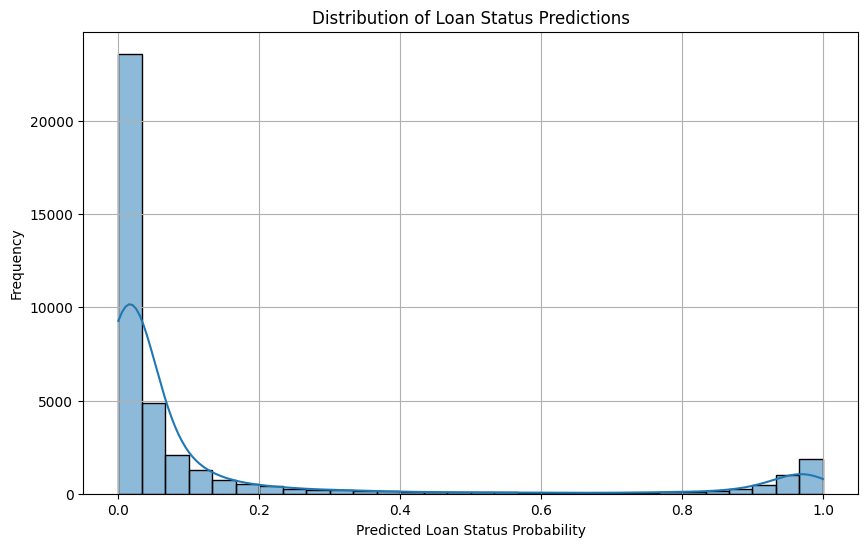

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the predictions
plt.figure(figsize=(10, 6))
sns.histplot(submission['loan_status'], bins=30, kde=True)
plt.title('Distribution of Loan Status Predictions')
plt.xlabel('Predicted Loan Status Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
submission.to_csv('submission.csv', index=False)